# Page Rank
__`Implementing Page rank`__

Goal is to implement distributed PageRank using some data from Wikipedia.

Important concepts covered:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.



# Notebook Set-Up
Run the following cells to confirm setup.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
# RUN THIS CELL AS IS. 
tot = 0
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
for item in dbutils.fs.ls(DATA_PATH):
  tot = tot+item.size
tot
# ~4.7GB

Out[2]: 4751198766

In [0]:
# RUN THIS CELL AS IS. You should see all-pages-indexed-in.txt, all-pages-indexed-out.txt and indices.txt in the results. If you do not see these, please let an Instructor or TA know.
display(dbutils.fs.ls(DATA_PATH))

path,name,size
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt,all-pages-indexed-in.txt,2143300687
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt,all-pages-indexed-out.txt,2090459616
dbfs:/mnt/mids-w261/HW5/indices.txt,indices.txt,517438296
dbfs:/mnt/mids-w261/HW5/test_graph.txt,test_graph.txt,167


In [0]:
sc = spark.sparkContext
spark

Out[4]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.0.128.43:7077 
 AppName 
 Databricks Shell

# Question 1: Distributed Graph Processing


### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ An example of a dataset that would be appropriate to represent as a graph is social or professional networks. The nodes in this dataset would be the members (people) in the network. The edges represent the people's relationships or connections with other people. An `in-degree` of the node corresponds with the summation of all the edges that are incoming to it. The in-Degree is a property only for directed graphs. A graph representing a social network is 'undirected', since people's relationships or connections can be bi-directional. The degree of a node is the number of edges connected to it. The average 'in-degree' of a node in this graph will be the sum of the degree of all nodes divided by the total number of nodes.

> __b)__ Graphs are uniquely challenging to work with in a map-reduce paradigm because graph in general needs to be traversed sequentially and traversal paths propagated for statelessness and distributed computing. Graphs can be represented as a collection of key-value pairs where the key represents a node and the value as the adjacent nodes as an iterable. To represent a graph traversal all previous propagations are needed to establish actual propagation path. Records of nodes with 'frontier' status needs to be emitted at each step to maintain statelessness. Otherwise, the data structures and global state of a graph has to be maintained in memory to process the data using a map-reduce framework which is not typically feasible.  

> __c)__ Dijkstra's algorithm is a single-source shortest path search algorithm. This can be implemented on a single computer quite efficiently using stateful and mutable data structures like a priority queue or heap to maintain a global priority queue of nodes with priorities equal to their distance from the source node. After each iteration, processes the node with the shortest distance and updates the distance to all reachable nodes. In Python, this is done using functions from the heapq library applied to an initialized empty list. Due to the stateful and mutable nature of the global priority queue as a heap, Dijkstra's algorithm is not a candidate for parallel and distributed computing. 


> __d)__ Parallel breadth-first-search algorithm is an iterative process where each iteration represents a map-reduce job. It gets around the problem identified in part 'c' by using FIFO instead of a priority queue. A node in the 'frontier' using this approach is mapped independently for each degree of separation from the origin node. If there are n nodes in the frontier, the job can be divided into n independent tasks for an iteration and can be processed in parallel. However, parallel breadth-first-search requires multiple iterations to process all nodes.

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.

### Q2 Student Answers:
> __a)__ The graph represented here is sparse as it has a lot of zeroes. Sparsity impacts the adjacency matrix in a way that it requires more space due to its sparse nature. As a result, most computational implementations of graph algorithms operate over adjacency lists, in which a node is associated with neighbors that can be reached via outgoing edges. However, there are certain graph operations that are easier on adjaceny matrix than on adjacency list. 
> Sparsity is represented in adjacency matrix but it is not represented in adjacency list.

> __b)__ The toy graph is a directed graph. The adjacency matrices for directed graph will be more sparse than the undirected graph.

In [0]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

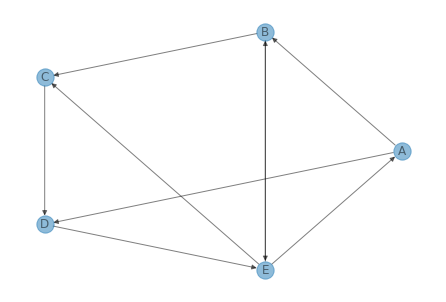

In [0]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for node in graph['nodes']:
      for edge in graph['edges']:
        if node == edge[0]: 
          adj_matr[edge[1]][edge[0]] = 1
    ############### (END) YOUR CODE #################
    return adj_matr

In [0]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

A B C D E
A 0 1 0 1 0
B 0 0 1 0 1
C 0 0 0 1 0
D 0 0 0 0 1
E 1 1 1 0 0

In [0]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################

    for node in graph['nodes']:
      if node not in graph:
        adj_list[node] = []
        
      for edge in graph['edges']:
        if edge[0] == node:
           adj_list[node].append(edge[1])
    
    ############### (END) YOUR CODE #################
    return adj_list

In [0]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}

# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ PageRank represents the relative importance of a web page in a hyperlinked network of webpages that comprise the world wide web. It measures the visit rate over an extended period of time (think "infinite time") and assigns a numerical weighting to each web page. 

> __b)__ Markov property refers to the memoryless characteristic of a stochastic process and states that the conditional probability distribution for the system at the next step depends only on the current state of the system, and not on the sequence of events that preceded it. <br> 
> Markov processes give us a principled approach to calculate the PageRank of each web page; PageRank is the steady state probability distribution of the Markov process underlying the random-surfer model of web navigation. 

> __c)__ In the context of PageRank & a random walk over the WebGraph, the $n$ states are the number of crawled web pages that are hyperlinked to form the WebGraph. These are the nodes that are traversed during a random walk while transitioning from one page to another. The transition matrix, a 'n x n' square matrix with n states, provides the probabilities of transition from one node or web page to another. Based on some studies done earlier this year, the world wide web has around 17.5 quadrillion different pages with Google indexing 35 trillion web pages. This will make the transition matrix extremely large. Most web pages are hyperlinked with a small number of pages, making the transition matrix a highly sparse matrix.      

> __d)__ A stochastic matrix is used to describe the transitions in a Markov chain and represented by a square matrix. A 'right stochastic matrix' is a square matrix of non-negative real numbers, with each row summing to 1.

> __e)__ The transition matrix converges after 4 iterations with the data as follows:
> Step 4: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
> 
> Node 'E' is the most 'central' and has the highest Rank. This matches our intuition as it has the highest number (2 in, 2 out) of edges connected to other nodes.

In [0]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

Out[11]:

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [0]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
#transition_matrix = None # replace with your code
transition_matrix = TOY_ADJ_MATR/np.sum(TOY_ADJ_MATR, axis=1).values.reshape(-1,1)
################ (END) YOUR CODE #################

print(transition_matrix)

A B C D E
A 0.000000 0.500000 0.000000 0.5 0.0
B 0.000000 0.000000 0.500000 0.0 0.5
C 0.000000 0.000000 0.000000 1.0 0.0
D 0.000000 0.000000 0.000000 0.0 1.0
E 0.333333 0.333333 0.333333 0.0 0.0

In [0]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    state_vector = xInit
    for ix in range(nIter):    
        
#         state_vector = state_vector@tMatrix
        tMatrix = tMatrix.dot(tMatrix)
        state_vector = state_vector.dot(tMatrix)
    
        if verbose:
            print(f'Iteration {ix}: {state_vector}')
    
    ################ (END) YOUR CODE #################
    return state_vector

In [0]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

Iteration 0: [0. 0. 0.25 0. 0.75]
Iteration 1: [0.14583333 0.20833333 0.20833333 0.25 0.1875 ]
Iteration 2: [0.10746206 0.15780928 0.18477929 0.23268711 0.31726225]
Iteration 3: [0.10525876 0.15789576 0.18420955 0.23685181 0.31578413]
Iteration 4: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Iteration 5: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Iteration 6: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Iteration 7: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Iteration 8: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Iteration 9: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.

### Q4 Student Answers:
> __a)__ We find that the probabilities do not converge and each row do not add up to 1 implying that the transition matrix is no longer stochastic.   

> __b)__ The Dangling node here is node 'E' because it has no outgoing links. Due to this, the graph doesn't converge. We can use Stochasticity to resolve dangling edges. With dangling nodes, the total PageRank mass will not be conserved, since no key-value pairs will be emitted when a dangling node is encountered in the mappers (missing mass).

> __c)__ A graph is irreducible if there is a path from every node to every other node, in other words, it is possible to get to any state from any other state. In a Webgraph, web pages are represented as nodes and links as edges and is not naturally irreducible.

> __d)__ A graph is aperiodic if the states are not partitioned into sets such that all state transitions occur cyclically from one set to another i.e., the greatest commom divisor (GCD), of all cycle lengths is 1. Webgraph is not naturally aperiodic.

> __e)__ In order to guarantee aperiodicity and irreducibility, the webgraph should be primitive. A primitive matrix is a square nonnegative matrix some power of which is positive. PageRank uses the ability to teleport from a page to another to address aperiodicity and irreducibility. This adds a small probability to each node to teleport to any other node providing the ability to exit from a dangling node. Teleportation takes the probability mass of dangling nodes and distributes it to other nodes allowing the switch from dangling webpages to other pages without a hyperlink.

In [0]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

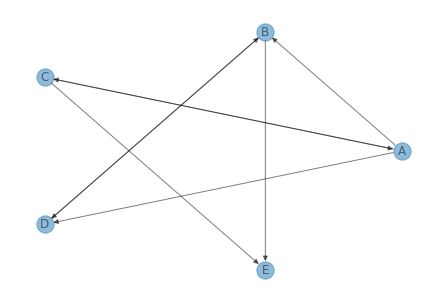

In [0]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################

# Get adjacency matrix using the functions get_adj_matr()
TOY2_ADJ_MATR = get_adj_matr(TOY2_GRAPH)

# Calculate the transition matrix
tMatrix2 = TOY2_ADJ_MATR/np.sum(TOY2_ADJ_MATR.to_numpy(), axis=1, keepdims=True)
print(tMatrix2)

# Calculate the state using the function power_iteration()
states = power_iteration(xInit, tMatrix2, 10, verbose = False)
print(f'The final states are: {states}')

################ (END) YOUR CODE #################

A B C D E
A 0.0 0.333333 0.333333 0.333333 0.0
B 0.0 0.000000 0.000000 0.500000 0.5
C 0.5 0.000000 0.000000 0.000000 0.5
D 0.0 1.000000 0.000000 0.000000 0.0
E NaN NaN NaN NaN NaN
The final states are: [nan nan nan nan nan]

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [0]:
dbutils.fs.ls(DATA_PATH)

Out[18]: [FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt', name='all-pages-indexed-in.txt', size=2143300687),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt', name='all-pages-indexed-out.txt', size=2090459616),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/indices.txt', name='indices.txt', size=517438296),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/test_graph.txt', name='test_graph.txt', size=167)]

In [0]:
# open test_graph.txt file to see format (RUN THIS CELL AS IS)
with open('/dbfs/mnt/mids-w261/HW5/test_graph.txt', "r") as f_read:
  for line in f_read:
    print(line)

2	{'3': 1}

3	{'2': 2}

4	{'1': 1, '2': 1}

5	{'4': 3, '2': 1, '6': 1}

6	{'2': 1, '5': 2}

7	{'2': 1, '5': 1}

8	{'2': 1, '5': 1}

9	{'2': 1, '5': 1}

10	{'5': 1}

11	{'5': 2}

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

In [0]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

Out[21]: ["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(10)

Out[22]: ['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [0]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(10)

Out[23]: ["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}"]

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ The format of the raw data is tab delimited text, for the 'testRDD' and the 'wikiRDD' where each line represents an adjacency list. The first part represent the source node ID and the second part correponds with a dictionary that contains the neighbor nodes and their edge weights. For example, in the 'testRDD' record: 2\t{'3': 1}, 2 corresponds to the source node ID, 3 is the neighbor node, and the weight between the source node ID and neighbor node 3 is equal to 1.

> __b)__ The raw dataset represents an adjacency list for the webgraph. A record has a key (node) and value (edges to other nodes). The number of records is not the same as the number of total nodes in the graph because of the presence of dangling nodes, assuming that there are no multiple entries (no duplicates).  

> __d)__ The number of dangling nodes in the wikipedia graph is as shown below:
> > - Dangling Nodes = Total nodes - Count the number of records = Number of dangling nodes
> > - Dangling Nodes = 15,192,277 - 5,781,290 = 9,410,987

In [0]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290
print(wikiRDD.count())

5781290

In [0]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
  
    def get_node(line):
      node, edges = line.split('\t')
      
      edges = ast.literal_eval(edges)
      nodes = list(edges.keys()) + [node]
      
      for node in nodes:
        yield node
    
    totalCount = dataRDD.flatMap(get_node) \
                    .map(lambda x: (x,1)).distinct() \
                    .count()
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [0]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 0.9041855335235596 seconds.
Total Nodes: 11

In [0]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 533.256840467453 seconds.
Total Nodes: 15192277

# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ In the context of the PageRank algorithm, the node's out-degree information is used to calculate the transition matrix \\(Q = D ^{-1} A\\) where D is the out-degree matrix and A is the adjacent matrix. This is used to identify dangling nodes and their respective ranks. 

> __c)__ If a node's out-degree is 0, this means that the node is a dangling node and does not have an out-going edge/link. In PageRank, dangling nodes results in loss of mass which is also the weight of the dangling node. This loss is redistributed evenly across all the nodes in the graph by adding a small amount of probability to each node to represent teleportation from the dangling node to any other node.

In [0]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############

    outDegrees = dataRDD.map(parse) \
                    .map(lambda x: (x[0], len(list(x[1].values())))) \
                    .cache()
    
    # sort by outdegree length
    top = outDegrees.takeOrdered(10, key=lambda x: -x[1])
    
    # Calculate average outdegree
    avgDegree = outDegrees.map(lambda x: x[1]).mean()

    # sample
    samples = outDegrees.takeSample(False, n)
    sampledCounts =  [x[1] for x in samples]
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [0]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

... completed job in 0.4438648223876953 seconds
Average out-degree: 1.7
Top 10 nodes (by out-degree:)
 [('5', 3), ('4', 2), ('6', 2), ('7', 2), ('8', 2), ('9', 2), ('2', 1), ('3', 1), ('10', 1), ('11', 1)]

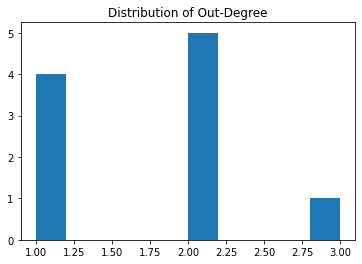

In [0]:
# part a - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [0]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)

print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

... completed job in 148.8501455783844 seconds
Average out-degree: 24.58172086160741
Top 10 nodes (by out-degree:)
 [('7883280', 7132), ('7884831', 5877), ('6075450', 5875), ('6074992', 5855), ('7828359', 5839), ('7880980', 5692), ('1008643', 5598), ('7828391', 5597), ('7873008', 5573), ('7841582', 5530)]

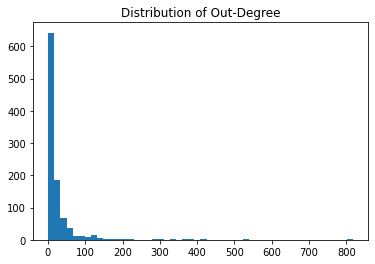

In [0]:
# part a - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code \\(N\\).

### Q7 Tasks:
* __a) short response:__ What is \\(N\\)? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to \\(\frac{1}{N}\\). (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ N is the total number of nodes in the graph that are processed including dangling nodes. We initialize each node's rank (initial weight) to \\(\frac{1}{N}\\) to represent uniform probability for each node, such that the sum of the weights for all nodes equals to 1. The total percentage of time spent by the random web-surfer at a page can be interpreted by the weight associated with it. Given N number of nodes, a random surfer has n ways to go to another node. i.e at any point of time in graph navigation, there is 1/N probability to go to another node. This is nothing more than the steady state probability distribution of the markov process underlying the random surfer model of web navigation.  

> __b)__ Computing N before initializing the records for each dangling node is better and more efficient because all nodes are initialized to uniform probability at the same time and the initial ranks can be set, during initializing records for each dangling node. However, it may be easy to get the value of N after we know the number of dangling nodes.

In [0]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############
  
    # write any helper functions here
                    
    # Emit node (key) and (weight, [edges])
    def emitnode(line):
      '''
      Function that takes the RDD format ("5\t{'4': 3, '2': 1, '6': 1}") 
      and generates output: ('5', (1/n, [('4',3), ('2',1), ('6',1)]))
      '''

      # Split line
      node, edges_dict_str = line.split('\t')
      #convert edges string to dictionary  
      edges_dict = ast.literal_eval(edges_dict_str)  
      # Rank of 1/N for each node
      initrank = 1/n.value
      # Calculate weight
      weight = float(1.0 * initrank)
      
      # Emit (node, (weight, [edges])) for every key, the empty list will take care of dangling nodes
      for nd in edges_dict.keys():
        if (edges_dict.get(nd) == 1):
          yield (nd, (weight, []))
        yield (node, (weight, list(edges_dict.items()))) 
        
    # Merge node edges  
    def merge(d1, d2):
      '''
      Function returns weight and merged edges.
      '''
      weight1, edge_list1 = d1 
      weight2, edge_list2 = d2
      return (weight1, list(set(edge_list1 + edge_list2)))
      
    # write your main Spark code here
    
    # Broadcast total number of nodes
    n = sc.broadcast(count_nodes(dataRDD)) 
        
    graphRDD = dataRDD.flatMap(lambda x: emitnode(x)) \
                      .reduceByKey(lambda x, y: merge(x, y))
                      
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [0]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.46318960189819336 seconds.
Out[34]: [('8', (0.09090909090909091, [('5', 1), ('2', 1)])),
 ('9', (0.09090909090909091, [('5', 1), ('2', 1)])),
 ('10', (0.09090909090909091, [('5', 1)])),
 ('1', (0.09090909090909091, [])),
 ('4', (0.09090909090909091, [('2', 1), ('1', 1)])),
 ('3', (0.09090909090909091, [('2', 2)])),
 ('2', (0.09090909090909091, [('3', 1)])),
 ('5', (0.09090909090909091, [('2', 1), ('4', 3), ('6', 1)])),
 ('6', (0.09090909090909091, [('2', 1), ('5', 2)])),
 ('7', (0.09090909090909091, [('5', 1), ('2', 1)])),
 ('11', (0.09090909090909091, [('5', 2)]))]

In [0]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 550.081431388855 seconds

In [0]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 14802997
First record: [('15180114', (6.582291778908455e-08, []))]
... initialization continued: 2016.3756444454193 seconds

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ In terms of the infinite random walk analogy, the first term represents the probability of teleportation or random jump (1 - \\\(\alpha\\)) "damping factor" divided by `|G|` the number of nodes. 
> $\alpha is the teleportation factor, $\alpha * \frac{1}{|G|}$ means uniform distribution for teleportation across all nodes in the graph, meaning a random surfer can go from current node to any other node in randomly uniform way.

> __b)__ In the equation for the PageRank calculation, \\(m\\) represents the total dangling node PageRank mass that is lost due to dangling nodes. \\(m\\) is divided by the total number of nodes because each node gets the same share of the dangling mass to preserve the PageRank calculations.

> __c)__ The total mass should be one after each iteration across the graph. This is the sum of the PageRank probabilities of the web surfer being on a node which gets redistributed after each iteration. We can keep track of the total probability mass using the verbose mode to confirm that the algorithm is on track.

In [0]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [0]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # Teleportation:
    a = sc.broadcast(alpha)
    
    # Damping factor:
    d = sc.broadcast(1-a.value)
    
    # Initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
        
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.
    
    # Calculate probability of each node ('node', (prob,[]))
    def node_prob(x):
      return x[1][0]
    
    # Calculate total weight of all of the edges for non-dangling nodes 
    # ('node_id', (prob, [('5', 1), ('2', 1)])) = 1+1 = 2
    def neighbor_node_total_weight(edges):
      return sum(weight for  neighbor_node, weight in edges)
    
    # Calculate PageRank contribution
    # input ('node_id', (prob, [('5', 1), ('2', 1)]), 2)
    def pr_contribution(x):
      node_id, node_payload, total_weight = x
      node_prob, edges = node_payload
         
      # Yield neighbor_node and payload with updated probability
      for neighbor_node, weight in edges:
        yield (neighbor_node, (node_prob * weight/total_weight, []))
      
      # Yield node and payload    
      yield (node_id, (0, edges))    
    
    # Merge node edges  
    def merge_prob_edges(d1, d2):

      weight1, edge_list1 = d1 
      weight2, edge_list2 = d2
      
      return (weight1 + weight2, list(set(edge_list1 + edge_list2)))
    
    # Calculate total PageRank - use teleportation and dangling mass
    def pagerank_tot(x):

      nonteleport_value = (d.value * ((danglingMass.value/n.value) + x[0]))
      teleport_value = (a.value/n.value)
      pageRank_value = (nonteleport_value + teleport_value)

      return (pageRank_value, x[1])
      
    ##################END-HELPER######################################
    
    # Broadcast total nodes count 
    n = sc.broadcast(graphInitRDD.count()) 
    
    # Spark job to implement page rank
    for i in range(maxIter):
      # initialize accumulators for dangling mass & total mass
      # for each iteration
      mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
      totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
     
      # get dangling node mass for non-dangling nodes
      # (filtering dangling nodes)
      graphInitRDD.filter(lambda a: a[1][1] == []) \
                  .foreach(lambda a: mmAccum.add(node_prob(a)))
     
      # MapReduce job
      graphInitRDD = graphInitRDD.map(lambda a: (a[0], a[1], neighbor_node_total_weight(a[1][1]))) \
                                 .flatMap(lambda a: pr_contribution(a)) \
                                 .reduceByKey(lambda a, b: merge_prob_edges(a, b)) \
                                 .cache()
      
      # Broadcast dangling_mass
      danglingMass = sc.broadcast(mmAccum.value)
      
      # Calculate PageRank using teleportation and damping factors
      graphInitRDD = graphInitRDD.mapValues(lambda dm: pagerank_tot(dm))
      
      # check if totAccum is equal to 1 
      graphInitRDD.foreach(lambda x: totAccum.add(x[1][0]))
      if verbose:
        print("Iteration {}, Total probability {} ".format(i, totAccum.value))
      assert totAccum.value > 0.99
      
    # Output: node_id, pageRank
    steadyStateRDD = graphInitRDD.map(lambda a: (int(a[0]), a[1][0]))
    
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [0]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

...trained 20 iterations in 6.614922523498535 seconds.
Top 20 ranked nodes:
Out[39]: [(2, 0.3620640495978872),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (9, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (11, 0.01692511778009981)]

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

In [0]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

Iteration 0, Total probability 0.9954384524024147 
Iteration 1, Total probability 1.0110963934214214 
Iteration 2, Total probability 1.0237905808686674 
Iteration 3, Total probability 1.034420454107491 
Iteration 4, Total probability 1.0434447777190776 
Iteration 5, Total probability 1.051151180598463 
Iteration 6, Total probability 1.057750028784004 
Iteration 7, Total probability 1.0634078581672268 
Iteration 8, Total probability 1.0682620274312775 
Iteration 9, Total probability 1.0724280978234106 
...trained 10 iterations in 12246.606081962585 seconds.
Top 20 ranked nodes:
Out[40]: [(13455888, 0.0016483443077108615),
 (4695850, 0.0007167001515088286),
 (1184351, 0.0006419733734514514),
 (5051368, 0.0006390798485361758),
 (2437837, 0.0004935188612750985),
 (6076759, 0.0004863889778665052),
 (4196067, 0.0004724284655861838),
 (13425865, 0.0004701060344016454),
 (6172466, 0.0004514232056679379),
 (1384888, 0.0004309485200130813),
 (6113490, 0.0004249989538546294),
 (14112583, 0.000419924812582346),
 (7902219, 0.0003951911192977627),
 (10390714, 0.0003893730790750138),
 (12836211, 0.00038397957216651117),
 (6237129, 0.00037557448170087845),
 (6416278, 0.00037240712468538046),
 (13432150, 0.0003616622426939041),
 (1516699, 0.0003554029453439947),
 (7990491, 0.00032767299284518437)]

__`expected results (posted by Vinicio):`__
```
top_20 = [(13455888, 0.0015447247129832947),
 (4695850, 0.0006710240718906518),
 (5051368, 0.0005983856809747697),
 (1184351, 0.0005982073536467391),
 (2437837, 0.0004624928928940748),
 (6076759, 0.00045509400641448284),
 (4196067, 0.0004423778888372447),
 (13425865, 0.00044155351714348035),
 (6172466, 0.0004224002001845032),
 (1384888, 0.0004012895604073632),
 (6113490, 0.00039578924771805474),
 (14112583, 0.0003943847283754762),
 (7902219, 0.000370098784735699),
 (10390714, 0.0003650264964328283),
 (12836211, 0.0003619948863114985),
 (6237129, 0.0003519555847625285),
 (6416278, 0.00034866235645266493),
 (13432150, 0.00033936510637418247),
 (1516699, 0.00033297500286244265),
 (7990491, 0.00030760906265869104)]
```

In [0]:
top_20 = full_results.takeOrdered(20, key=lambda x: - x[1])

In [0]:
# Save the top_20 results to disc for use later. So you don't have to rerun everything if you restart the cluster.
#dbutils.fs.put(hw5_path+"top20_wiki.csv", pd.DataFrame(top_20, columns = ["Index", "PageRank"]).to_csv()) 
dbutils.fs.put("/tmp/team11/" + "top20_wiki_110721.csv", pd.DataFrame(top_20, columns = ["Index", "PageRank"]).to_csv()) 

display(dbutils.fs.ls("/tmp/team11/"))

Wrote 675 bytes.

path,name,size
dbfs:/tmp/team11/top20_wiki.csv,top20_wiki.csv,676
dbfs:/tmp/team11/top20_wiki_110721.csv,top20_wiki_110721.csv,675


In [0]:
# view record from indexRDD (RUN THIS CELL AS IS)
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

Out[43]: ['! $var = &quot;&quot;\t1\t1\t0']

In [0]:
# map indexRDD to new format (index, name) (RUN THIS CELL AS IS)
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
# see new format (RUN THIS CELL AS IS)
namesKV_RDD.take(2)

Out[45]: [(1, '! $var = &quot;&quot;'), (2, '! (CONFIG.SYS directive)')]

In [0]:
indexRDD.take(10)

Out[46]: ['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [0]:
namesKV_RDD.take(10)

Out[47]: [(1, '! $var = &quot;&quot;'),
 (2, '! (CONFIG.SYS directive)'),
 (3, '! (album)'),
 (4, '! (disambiguation)'),
 (5, '! -attention-'),
 (6, '! Time Zone'),
 (7, '!! (chess)'),
 (8, '!! (disambiguation)'),
 (9, '!!! (Chk Chk Chk)'),
 (10, '!!! (album)')]

# OPTIONAL
### The rest of this notebook is optional and doesn't count toward your grade.
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

## Join with indexRDD and print pretty

In [0]:
#DELETE testing - DC
df1 = spark.read.csv("/tmp/team11/top20_wiki_110721.csv", header=True, inferSchema= True)
display(df1)

_c0,Index,PageRank
0,13455888,0.0016483443077108615
1,4695850,7.167001515088286E-4
2,1184351,6.419733734514514E-4
3,5051368,6.390798485361758E-4
4,2437837,4.935188612750985E-4
5,6076759,4.863889778665052E-4
6,4196067,4.724284655861838E-4
7,13425865,4.701060344016454E-4
8,6172466,4.514232056679379E-4
9,1384888,4.309485200130813E-4


In [0]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StructField, StringType, LongType

schema = StructType([StructField("_c0",LongType(),True),StructField("Index",LongType(),True),StructField("PageRank",LongType(),True)])
top_20_DF = spark.read.csv("/tmp/team11/top20_wiki_110721.csv", header=True, schema=schema)

schema2 = StructType([StructField("Index",LongType(),True),StructField("Title",StringType(),True)])
namesKV_DF = spark.createDataFrame(namesKV_RDD, schema=schema2)

# namesKV_DF = spark.createDataFrame(namesKV_RDD, schema=['Index', 'Title'])
joinedWithNames = namesKV_DF.join(top_20_DF, namesKV_DF.Index==top_20_DF.Index).orderBy(F.desc("PageRank")).collect()

############## END YOUR CODE ###############

In [0]:
# # part a try #2
# joinedWithNames = None
# ############## YOUR CODE HERE ###############
# from pyspark.sql import functions as F
# from pyspark.sql.types import StructType,StructField, StringType, LongType

# # schema = StructType([StructField("_c0",LongType(),True),StructField("Index",LongType(),True),StructField("PageRank",LongType(),True)])
# top_20_DF = spark.read.csv("/tmp/team11/top20_wiki_110721.csv", header=True)

# # schema2 = StructType([StructField("Index",LongType(),True),StructField("Title",StringType(),True)])
# namesKV_DF = spark.createDataFrame(namesKV_RDD)

# # namesKV_DF = spark.createDataFrame(namesKV_RDD, schema=['Index', 'Title'])
# # joinedWithNames = namesKV_DF.join(top_20_DF, namesKV_DF.Index==top_20_DF.Index).orderBy(F.desc("PageRank")).collect()

# ############## END YOUR CODE ###############

In [0]:
top_20_DF.printSchema()

root
-- _c0: long (nullable = true)
-- Index: long (nullable = true)
-- PageRank: long (nullable = true)

In [0]:
namesKV_DF.printSchema()

root
-- Index: long (nullable = true)
-- Title: string (nullable = true)

In [0]:
display(joinedWithNames)

--------------------------------------------------------------------------- 
 ValueError Traceback (most recent call last)
 <command-2661063350703420> in <module> 
 ----> 1 display ( joinedWithNames ) 

 /databricks/python_shell/scripts/PythonShellImpl.py in display (self, input, *args, **kwargs) 
 986 self . appendResults ( "table" , input . _jdf ) 
 987 elif isinstance ( input , list ) : 
 --> 988 listDisplay = self . sparkSession . createDataFrame ( input ) . _jdf
 989 self . appendResults ( "table" , listDisplay ) 
 990 elif type ( input ) . __module__ == 'matplotlib.figure' and type ( input ) . __name__ == 'Figure' : 

 /databricks/spark/python/pyspark/sql/session.py in createDataFrame (self, data, schema, samplingRatio, verifySchema) 
 720 return super(SparkSession, self).createDataFrame(
 721 data, schema, samplingRatio, verifySchema)
 --> 722 return self . _create_dataframe ( data , schema , samplingRatio , verifySchema ) 
 723 
 724 def _create_dataframe ( self , data , schema , samplingRatio , verifySchema ) : 

 /databricks/spark/python/pyspark/sql/session.py in _create_dataframe (self, data, schema, samplingRatio, verifySchema) 
 752 rdd , schema = self . _createFromRDD ( data . map ( prepare ) , schema , samplingRatio ) 
 753 else : 
 --> 754 rdd , schema = self . _createFromLocal ( map ( prepare , data ) , schema ) 
 755 jrdd = self . _jvm . SerDeUtil . toJavaArray ( rdd . _to_java_object_rdd ( ) ) 
 756 jdf = self . _jsparkSession . applySchemaToPythonRDD ( jrdd . rdd ( ) , schema . json ( ) ) 

 /databricks/spark/python/pyspark/sql/session.py in _createFromLocal (self, data, schema) 
 528 write temp files . 
 529 """
 --> 530 data , schema = self . _wrap_data_schema ( data , schema ) 
 531 return self . _sc . parallelize ( data ) , schema
 532 

 /databricks/spark/python/pyspark/sql/session.py in _wrap_data_schema (self, data, schema) 
 507 
 508 if schema is None or isinstance ( schema , ( list , tuple ) ) : 
 --> 509 struct = self . _inferSchemaFromList ( data , names = schema ) 
 510 converter = _create_converter ( struct ) 
 511 data = map ( converter , data ) 

 /databricks/spark/python/pyspark/sql/session.py in _inferSchemaFromList (self, data, names) 
 440 schema = reduce ( _merge_type , ( _infer_schema ( row , names ) for row in data ) ) 
 441 if _has_nulltype ( schema ) : 
 --> 442 raise ValueError ( "Some of types cannot be determined after inferring" ) 
 443 return schema
 444 

 ValueError : Some of types cannot be determined after inferring

In [0]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

## OPTIONAL - GraphFrames
GraphFrames is a graph library which is built on top of the Spark DataFrames API.

* __a) code:__ Using the same dataset, run the graphframes implementation of pagerank.
* __b) code:__ Join the top 20 results with indices.txt and display in the same format as above.
* __c) short answer:__ Compare your results with the results from graphframes.

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import *
from pyspark.sql import functions as F

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

### You will need to generate vertices (v) and edges (e) to feed into the graph below. 
Use as many cells as you need for this task.

In [0]:
def initGraphEdges(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############
  
    # write any helper functions here
                    
    # Emit node (key) and (weight, [edges])
    def emitnode(line):
      '''
      Function that takes the RDD format ("5\t{'4': 3, '2': 1, '6': 1}") 
      and generates output: ('5', (1/n, [('4',3), ('2',1), ('6',1)]))
      '''

      # Split line
      node, edges_dict_str = line.split('\t')
      #convert edges string to dictionary  
      edges_dict = ast.literal_eval(edges_dict_str)  
      # rank of 1/N for each node
      initrank = 1/n.value
      # calculate weight
      weight = float(1.0 * initrank)
      
      # Emit (node, (weight, [edges])) for every key, the empty list will take care of dangling nodes
      for nd in edges_dict.keys():
        if (edges_dict.get(nd) == 1):
          yield (nd, (weight, []))
        yield (node, (weight, list(edges_dict.items()))) 
        
    # Merge node edges  
    def merge(d1, d2):
      '''
      Function returns weight and merged edges.
      '''
      weight1, edge_list1 = d1 
      weight2, edge_list2 = d2
      return (weight1, list(set(edge_list1 + edge_list2)))
      
    # write your main Spark code here
    
    # Broadcast total number of nodes
    n = sc.broadcast(count_nodes(dataRDD)) 
        
    graphRDD = dataRDD.flatMap(lambda x: emitnode(x)) \
                      .reduceByKey(lambda x, y: merge(x, y))
                      
    ############## (END) YOUR CODE ##############
    # ('5', (1/n, [('4',3), ('2',1), ('6',1)]))
    # ('5', [('4',3), ('2',1), ('6',1)])
    # Output: node_id, destination
    initGraphEdgesRDD = graphRDD.map(lambda a: (int(a[0]), a[1][1]))
    
    return initGraphEdgesRDD


In [0]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraphEdges = initGraphEdges(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraphEdges

In [0]:
# line = ('5', [('4',3), ('2',1), ('6',1)])
tuple_list = []
edge_key = []
def node_edges_list(line):
    for l in line:
    node, tuple_list = line
    for a_tuple in tuple_list:
      edge_key.append(a_tuple[0])
    return [node, edge_key, 'follow']
  
test_list = node_edges_list(testGraphEdges)  

In [0]:
#working
# line = ['5', ['4', '2', '6']]
# line = ['5', []]
pair = []

def pairs(line):
    if len(line[1]) > 0:
       
        for l in line[1]:
            pair_ind = (l[0],l)
            pair.append(pair_ind)

    return pair
  
edgesRDD = sc.parallelize(pairs(test_list))

edges_DF = spark.createDataFrame(edgesRDD, schema=['src', 'dest', 'relationship'])

In [0]:
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)

# See Demo10_workbook at the end
# define vertices (v) [id, name, age??]
joinedWithNames = v

# define edges_df [source, destination, relationship??]


In [0]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=10)

In [0]:
start = time.time()
top_20 = results.vertices.orderBy(F.desc("pagerank")).limit(20)
print(f'... completed job in {time.time() - start} seconds.')

In [0]:
%%time
top_20.show()

### Run the cells below to join the results of the graphframes pagerank algorithm with the names of the nodes.

In [0]:
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
namesKV_DF = namesKV_RDD.toDF()

In [0]:
namesKV_DF = namesKV_DF.withColumnRenamed('_1','id')
namesKV_DF = namesKV_DF.withColumnRenamed('_2','title')
namesKV_DF.take(1)

In [0]:
resultsWithNames = namesKV_DF.join(top_20, namesKV_DF.id==top_20.id).orderBy(F.desc("pagerank")).collect()

In [0]:
# TODO: use f' for string formatting
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in resultsWithNames:
    print ("{:6f}\t| {:10s}\t| {}".format(r[3],r[2],r[1]))

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform